In [1]:
import mesa
import geopandas as gpd
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import json
import re

In [2]:
sd_zips = gpd.read_file("Zip Codes/geo_export_a38603a0-51c6-4173-b442-f6f81034382f.shp")

<Axes: >

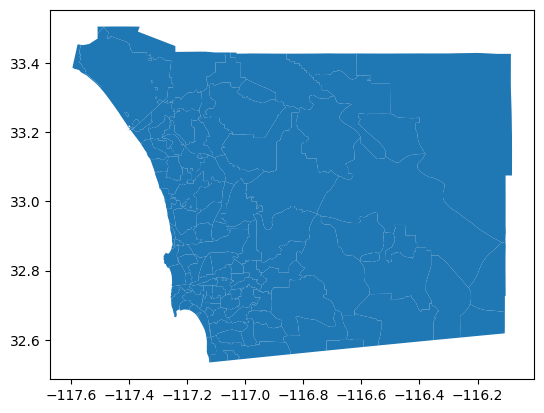

In [3]:
sd_zips.plot()

In [4]:
sd_zips.zip = sd_zips.zip.astype(int)
sd_zips.zip = sd_zips.zip.astype(str)

In [5]:
sd_zips

,community,shape_star,shape_stle,zip,totpop,tothh,avghhsz,totmales,totfemales,geometry
0,Alpine,4.149940e+09,326045.262676,91901,17818.0,6433.0,2.75,8915.0,8903.0,"POLYGON ((-116.74539 32.96063, -116.74085 32.9..."
1,Bonita,2.739094e+08,113257.374615,91902,18088.0,5998.0,3.00,8876.0,9212.0,"POLYGON ((-116.97172 32.70838, -116.97124 32.7..."
2,Boulevard,2.735681e+09,241725.552214,91905,1734.0,611.0,2.64,957.0,777.0,"POLYGON ((-116.23165 32.75083, -116.22809 32.7..."
3,Campo,3.066759e+09,287410.325075,91906,3910.0,1343.0,2.87,2046.0,1864.0,"POLYGON ((-116.35677 32.70460, -116.35729 32.7..."
4,Chula Vista,4.034374e+08,112587.791814,91910,79491.0,26684.0,2.93,39023.0,40468.0,"POLYGON ((-117.06354 32.65011, -117.06345 32.6..."
...,...,...,...,...,...,...,...,...,...,...
117,San Ysidro,1.103674e+08,52066.797099,92173,30126.0,8155.0,3.65,14545.0,15581.0,"POLYGON ((-117.06510 32.56911, -117.06397 32.5..."
118,San Diego,9.608105e+06,17525.597204,92182,2793.0,32.0,22.09,1306.0,1487.0,"POLYGON ((-117.07351 32.77926, -117.07049 32.7..."
119,Ocotillo,1.978752e+09,194340.478076,92259,23.0,13.0,1.77,13.0,10.0,"POLYGON ((-116.10322 32.87887, -116.10314 32.8..."
120,Aguanga,1.389177e+09,206176.033344,92536,357.0,141.0,2.15,201.0,156.0,"POLYGON ((-116.69356 33.42741, -116.68534 33.4..."


In [6]:
# geoenriched some population info to zipcode polygons, can add more such as elderly pop later (if that exists in geoenrichment)

In [6]:
# add NEIGHBORS column
zip_graph_dict = {}


for index, row in sd_zips.iterrows():  
    neighbors = sd_zips[sd_zips.geometry.touches(row['geometry'])].zip.tolist() 
    try:
        neighbors = neighbors.remove(row.zip)
    except:
        None
    
    zip_graph_dict[row.zip] = neighbors

In [7]:
alpine_neighbors = sd_zips.where(sd_zips.zip.isin(zip_graph_dict["91901"])).dropna()
alpine = sd_zips[sd_zips.zip == "91901"]

<Axes: >

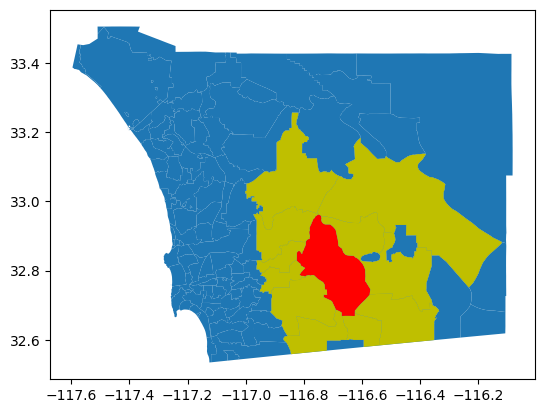

In [8]:
# using touches is not perfect

base_map = sd_zips.plot()
alpine.plot(color='r', ax=base_map)
alpine_neighbors.plot(color='y', ax=base_map)

In [9]:
# should use buffer on zipcode polygons

In [10]:
class Node:
    def __init__(self, zip_code, geom=None):
        self.zip_code = zip_code
        self.neighbors = []
        self.virus = None
        self.agency = []
        self.geom = geom
        self.infected = 0
        self.active_activities = {}
        self.population = int(sd_zips[sd_zips['zip'] == zip_code]['totpop'].values[0])
        
        
    def __str__(self):
        return self.zip_code
    
    def add_neighbor(self, neighbor_node):
        self.neighbors.append(neighbor_node)

In [11]:
graph = {}
for z in sd_zips.zip:
    graph[z] = Node(z)

In [12]:
for z in sd_zips.zip:
    neighbors = zip_graph_dict[z]
    for n in neighbors:
        graph[z].add_neighbor(graph[n])

In [13]:
actions = pd.read_csv("RCM_activities.csv")
budget_actions = actions[:3]
budget_actions['budget'] = ["100-2000", "50-200", "1000-3000"]

C:\Users\sky\AppData\Local\Temp\ipykernel_2000\4233098810.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  budget_actions['budget'] = ["100-2000", "50-200", "1000-3000"]


In [14]:
sd_actions = actions[actions['Specific Activity (SD)'].notna()]
sd_actions
# use curve and sample point to tell model effectiveness vs budget spent

,Response Item,System Component,Activity - source white house 2021 plan,Specific Activity (US),System variable,Value (units),Specific Activity (SD),System variable,Value 0:1,Specific Activity (Team X),System variable.1
0,Detection,Public health surveillance systems,"Monitoring for cases of the virus, both sympto...",CDC will deploy teams to affected areas to con...,Syndromic Surveillance,0.505164,San Diego County will use syndromic surveillan...,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,San Diego County will work with local universi...,Wastewater surveillance,NaN,NaN,NaN
2,NaN,Contact tracing systems,Contact tracing to identify people who have be...,CDC will provide funding and technical assista...,CT converter,0.700187,SD enacts manual CICT,Contact Tracing and Case Identification,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,San Diego County will add smartphone-based con...,EN,NaN,NaN,NaN
4,NaN,Laboratory testing systems,Sequencing the virus to track its evolution.,CDC will support the development of new labora...,Testing multiplier? Timing?,NaN,PCR testing,Central testing,0.700659,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,Sequencing,Sequencing,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,POC testing,POC testing,0.000000,NaN,NaN
7,Community Mitigation Measures,Public health messaging systems,Public health messaging to inform the public a...,CDC will develop and distribute public health ...,Protective behavior converter?,NaN,San Diego County will partner with local media...,Protective behavior rate,NaN,NaN,NaN
8,NaN,Social media platforms,Social media campaigns to promote public healt...,CDC will use social media to promote public he...,NaN,NaN,San Diego County will work with local communit...,Protective behavior rate,NaN,NaN,NaN
9,NaN,Law enforcement agencies,"Enforcement of public health measures, such as...",CDC will provide guidance to law enforcement a...,NaN,NaN,San Diego County will work with local law enfo...,Protective behavior rate,NaN,NaN,NaN


In [15]:
action_budget_str = "\n ".join(budget_actions[['Specific Activity (SD)' , 'budget']].apply(lambda row: "activity: " + row['Specific Activity (SD)'] + " budget range: " + str(row['budget']), axis = 1))

In [16]:
action_budget_str

'activity: San Diego County will use syndromic surveillance  to detect the virus. budget range: 100-2000\n activity: San Diego County will work with local universities to develop and deploy wastewater testing. budget range: 50-200\n activity: SD enacts manual CICT budget range: 1000-3000'

In [20]:
import openai

key_path = "../generative-geoact/notebooks/openai_api_key"
#openai.organization = "org-D3T7qkglEsZGgYNCoTz3Uocx"
with open(key_path, "r") as f:
    api_key = f.readline()
openai.api_key = api_key

In [21]:
def generate_text(prompt_background, prompt_text, use_openai = False, model_version = "gpt-3.5-turbo"):
    if use_openai:
        print("using openai "+model_version)
        completion = openai.ChatCompletion.create(
            model=model_version,
            messages=[
            {"role": "system", "content": prompt_background},
            {"role": "user", "content": prompt_text}
            ]
            )

        return completion.choices[0].message['content']
    else:
        # merge background and question for simple model
        prompt = prompt_background + prompt_text
        return language_model(prompt, do_sample=True, min_length=10, max_length=len(prompt)+128)[0]["generated_text"]
    

In [32]:
prompt_background = "Imagine you are San Diego Human Health and Services Agency"
prompt_text = "There currently are {}".format("31 covid cases in zipcode 92122, 10 covid cases in zipcode 92111")
# change this 
prompt_text += " You are responsible of zipcode: {}".format("92122, 92037")
prompt_text += " You can perform the following activities to mitigate covid effect in your responsible area: {}".format(" ".join(actions["Specific Activity (SD)"][:3]))
# for each type of action, give return of investment curve, diminishing return for high budget
prompt_text += " You currently have a total budget of {} units.".format(8000)
prompt_text += " The budget range for each activities are: {}".format(action_budget_str)
prompt_text += " What activites would you perform? What budget would you deploy for the chosen methods? On which zipcode?"

In [33]:
# make a log file
out = generate_text(prompt_background, prompt_text, use_openai = True)

using openai gpt-3.5-turbo


In [34]:
out

'As the San Diego Human Health and Services Agency, I would prioritize the following activities to mitigate the spread of COVID-19 in the designated zip codes:\n\n1. San Diego County will use syndromic surveillance to detect the virus.\n2. San Diego County will work with local universities to develop and deploy wastewater testing.\n\nFor the specified activities and zip codes:\n\n1. Syndromic Surveillance: I would allocate a budget of 2000 units for the implementation of syndromic surveillance in zip code 92122, considering it currently has a higher number of COVID-19 cases.\n\n2. Wastewater Testing: I would allocate a budget of 50 units for the implementation of wastewater testing in zip code 92122. Although zip code 92111 also has cases, the budget allocation is lower due to its smaller number of reported cases.\n\nIt is important to note that the budget ranges provided are very broad, and the final allocation may vary based on specific operational needs and cost estimates. Additiona

In [36]:
prompt_text = "Explain why you chose the activities and budgets in the following paragraph."
prompt_text += "\n"
prompt_text += out

generate_text("", prompt_text, use_openai = True)

using openai gpt-3.5-turbo


'The activities and budgets described in the paragraph are chosen based on the goal of mitigating the spread of COVID-19 in the designated zip codes. The chosen activities are syndromic surveillance and wastewater testing, which can help in detecting and monitoring the virus.\n\nFor syndromic surveillance, the budget allocation is determined by the number of COVID-19 cases in zip code 92122. This zip code is prioritized because it currently has a higher number of cases, indicating a higher risk of transmission. Therefore, a larger budget of 2000 units is allocated to ensure effective implementation and monitoring.\n\nFor wastewater testing, the budget allocation is determined by the number of reported cases in zip codes 92122 and 92111. While both zip codes have cases, zip code 92122 has a higher number, so a larger budget allocation of 50 units is allocated to implement wastewater testing. Zip code 92111, with a smaller number of reported cases, receives a smaller budget allocation, r

In [25]:

prompt_background = ""
prompt_text  = "Using bullet points, summarize the covid prevention activities performed on each zipcode and the assigned budget value in the next paragraph."
prompt_text += "\n"
prompt_text += out
b_out = generate_text(prompt_background, prompt_text, use_openai = True)
b_out

using openai gpt-3.5-turbo


'- Syndromic Surveillance in Zipcode 92122: Budget of 2000 units\n- Wastewater Testing in Zipcode 92122: Budget of 125 units\n- Syndromic Surveillance in Zipcode 92037: Budget of 2000 units'

In [26]:
prompt_text ='Transform the following bullet points to python dictionary format with zipcode string as key, activities as sub-key, budget value as values.'
prompt_text += b_out
d_out = generate_text(prompt_background, prompt_text, use_openai = True)

using openai gpt-3.5-turbo


In [27]:
json.loads(d_out.replace("\n",""))

{'92122': {'Syndromic Surveillance': 2000, 'Wastewater Testing': 125},
 '92037': {'Syndromic Surveillance': 2000}}

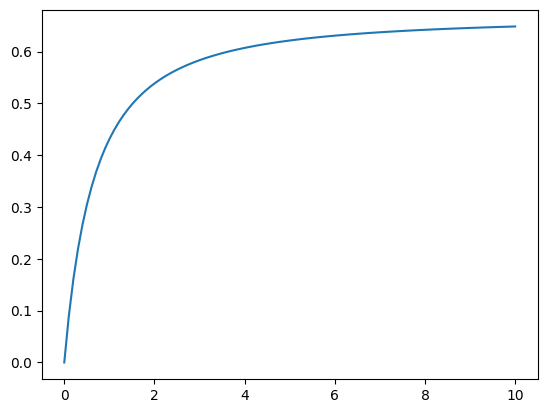

In [28]:
# dummy diminishing return curves 
x = np.linspace(0, 10, 100)
n = 2.5
z =  ((x+1)**(1-n) - 1)/(1-n)
plt.plot(x, z)

In [40]:
# dummy modifiers to fit budget range to curve
SYNDROMIC_SURVEILLANCE = 100/2000
WASTEWATER_TESTING = 100/2000
CICT = 100/3000

z[int(SYNDROMIC_SURVEILLANCE*2000)-1]

0.648393251843772

In [168]:
# why machine make such decision
# summarize to actual human


class Agency(mesa.Agent):

    def __init__(self, unique_id, model, name, zip_codes, budget):
        super().__init__(unique_id, model)
        self.name = name
        self.zip_codes = zip_codes
        self.budget = budget
        
    def step(self):
        prompt_background = "Imagine you are ".format(self.name)
        prompt_text = "There currently are {}".format(self.eval_status())
        
        # if agency is something like UCSD that only is responsible to a certain zipcodes
        if self.zip_codes != None:
            prompt_text += " Zipcodes that are within your legislative district are: {}".format(", ".join(self.zip_codes))
            
        prompt_text += " You can perform the following activities to mitigate covid effect: {}".format(" ".join(actions["Specific Activity (SD)"][:3]))
        prompt_text += " You currently have a total resource of {} units.".format(self.budget)
        prompt_text += " The budget range for each activities are: {}".format(action_budget_str)
        prompt_text += " Please do not allocate more than 10% of the total budget to activities."
        prompt_text += " What activites would you perform? What budget would you deploy for the chosen methods? On which zipcode?"
        # get rich output from LLM to maximize activity diversity
        rich_out = generate_text(prompt_background, prompt_text, use_openai = True)
        
        print(rich_out)
        
        # use LLM to summarize rich output
        prompt_background = ""
        prompt_text  = "Using bullet points, summarize the covid prevention activities performed on each zipcode and the assigned budget value in the next paragraph."
        prompt_text += " Make sure to include information such as zipcode, actual activity name, and budget value in units."
        prompt_text += "\n"
        prompt_text += rich_out
        b_out = generate_text(prompt_background, prompt_text, use_openai = True)
        
        print(b_out)
        
        # use LLM to transform to desired JSON/dictionary format without too much logistics in regex
        prompt_text ='Transform the following bullet points to python dictionary format with zipcode string as key, activities as sub-key, budget value as values.'
        prompt_text += b_out
        d_out = generate_text(prompt_background, prompt_text, use_openai = True)
        
        print(d_out)
        budget_use = json.loads(d_out.replace("\n","").replace("'", '"'))
        
        print(budget_use)
        for z in budget_use:
            if z in graph.keys():
                self.model.graph[z].active_activities = budget_use[z]
            
                # remove budget allocated to activities
                for val in budget_use[z].values():
                    try:
                        self.budget -= int(re.findall(r'\d+', str(val))[0])
                    except:
                        pass

                
  

    def eval_status(self):
        
        # check zip status
        out = ""
        for node in self.model.graph.values():
            if node.infected > 0:
                out += "{} covid cases in zipcode {}, ".format(node.infected, node.zip_code)      
                
        return out

In [31]:
graph['91901']

In [186]:
class Virus(mesa.Agent):

    def __init__(self, unique_id, model, zip_code):
        super().__init__(unique_id, model)
        
        # grab base transmission rate 
        # dummy stat from https://virologyj.biomedcentral.com/articles/10.1186/s12985-021-01609-w
        self.trans_rate = 0.0112
        self.zip_code = zip_code
        self.model.graph[zip_code].virus = self
        
        
    def step(self):
        print(self.trans_rate)
        # infect self
        base_node = self.model.graph[self.zip_code]
        exposed = self.infect(base_node.active_activities, base_node.infected, self.trans_rate)
        base_node.infected += exposed
        # transmit to neighbors
        # dummy model
        new_virus_count = 0
        for node in self.model.graph[self.zip_code].neighbors:
            if node.virus == None:
                # do sth with population, commute
                trans_prob = min(1,self.trans_rate*node.population*(base_node.infected/base_node.population))
                if np.random.choice([True, False], p = [trans_prob, 1-trans_prob]):
                    new_virus_count += 1
                    virus = Virus(unique_id=self.unique_id+"-"+str(new_virus_count), 
                      model=self.model, 
                      zip_code=node.zip_code)
                    
                    node.infected += trans_prob*self.infect(base_node.active_activities, base_node.infected, self.trans_rate)
                    self.model.schedule.add(virus)
    
    @staticmethod
    def infect(activities, infected, trans_rate):
        activity_modifier = 1
        for act in activities:
            # hard coded vals:
            if "SURVEILLANCE" in act.upper():
                activity_modifier *= 1 - z[int(SYNDROMIC_SURVEILLANCE*activities[act])-1]
            elif "WATER" in act.upper():
                activity_modifier *= 1 - z[int(WASTEWATER_TESTING*activities[act])-1]
            elif "CICT" in act.upper() or "CONTACT" in act.upper():
                activity_modifier *= 1 - z[int(CICT*activities[act])-1]
        
        # this is a dummy infection model
        return infected*trans_rate*activity_modifier*24*30

In [187]:
class NaiveModel(mesa.Model):
    def __init__(self, graph):

        self.running = True
        self.schedule = mesa.time.BaseScheduler(self)
        
        self.graph = graph
        # currently using dummy curve
        #self.curves = curves
        
        # add hardcoded agents
        sdhhsa = Agency(unique_id='SDHHSA',
                        model=self, 
                        name="San Diego Human Health and Services Agency", 
                        zip_codes=None, 
                        budget=20000)
        self.schedule.add(sdhhsa)
        
        virus = Virus(unique_id="BASE", 
                      model=self, 
                      zip_code="92037")
        self.schedule.add(virus)
        
        
    def step(self):
        '''
        step function of the model that would essentially call the step function of all agents
        '''
        # inject random 10-50 init patients to starting zipcode
        if self.schedule.time==0:
            # currently hard coded to 92037 as init zip
            self.graph['92037'].infected = np.random.choice(np.arange(10,50))
            
            
        self.schedule.step()

In [188]:
model = NaiveModel(graph)

In [189]:
model.schedule.time

0

In [190]:
model.step()

using openai gpt-3.5-turbo
Based on the given information, there are three activities that can be performed to mitigate the effects of COVID-19 in zipcode 92037:

1. San Diego County will use syndromic surveillance to detect the virus.
2. San Diego County will work with local universities to develop and deploy wastewater testing.
3. SD enacts manual CICT (Contact Investigation and Case Tracking).

To determine the budget allocation for each activity, we need to consider the budget ranges provided:

1. Syndromic Surveillance:
   - Budget range: $100-2000

2. Wastewater Testing:
   - Budget range: $50-200

3. Manual CICT (Contact Investigation and Case Tracking):
   - Budget range: $1000-3000

To decide which activities to prioritize, we need to consider the current situation in zipcode 92037, which has 47 COVID-19 cases. 

Considering the urgency and potential impact, the following strategy can be adopted:

1. Prioritize Syndromic Surveillance:
   - Syndromic surveillance is essential f

In [192]:
for agent in model.schedule.agents:
    if type(agent) == Virus:
        print("INFECTED:")
        print(model.graph[agent.zip_code].infected)
        print("NEIGHBOR COUNT")
        print(len(model.graph[agent.zip_code].neighbors))

INFECTED:
83.0996183866192
NEIGHBOR COUNT
20
